# Showing the whole video

In [36]:
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config

os.environ["CUDA_VISIBLE_DEVICES"] = "1,7"

conf = models_genesis_config()
config = get_config()
tasks = ['EF','SmallFrame' , 'LargeFrame', 'SmallTrace' ,'LargeTrace']
kwargs = {"target_type": tasks,
          "mean": 0,
          "std": 1,
          "mode":"self_supervised_video"
          }
traindataset = Echo(root='/AS_Neda/echonet/', split="train",**kwargs,conf = conf)
#train_loader = torch.utils.data.DataLoader(
#                    traindataset, batch_size=16, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
#video,target = next(iter(train_loader))

In [37]:
video,deform,label,target = traindataset[750]
deform.shape

NameError: name 'img_deps' is not defined

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots()
video,deform,label,target = traindataset[750]
print('label',label)
video = (np.array(deform)).transpose((1,2,3,0))
frames = [[ax.imshow(video[i],cmap='gray')] for i in range(len(video))]
ani = animation.ArtistAnimation(fig, frames)
ani

## Training model for segmentation

In [ ]:
# Load trained segmentation model
import torchvision
import math
import os
import time
from echonet_dataset import Echo
import click
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import skimage.draw
import torch
import torchvision
import tqdm
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config
import torch

# GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "1,7"

# Set device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get config
conf = models_genesis_config()
config = get_config()

# Preparing echinet dataset
tasks = ['EF','SmallFrame' , 'LargeFrame', 'SmallTrace' ,'LargeTrace']
kwargs = {"target_type": tasks,
          "mean": 0,
          "std": 1,
          "mode":"train"
          }
traindataset = Echo(root='/AS_Neda/echonet/', split="train",**kwargs)

# Generating dataloader
dataloader = torch.utils.data.DataLoader(
    traindataset, batch_size=16, num_workers=4, shuffle=True, pin_memory=(device.type == "cuda"), drop_last=True)


# Preparing Segmentation model 
model = torchvision.models.segmentation.deeplabv3_resnet50(aux_loss=False)
model.classifier[-1] = torch.nn.Conv2d(model.classifier[-1].in_channels, 1, kernel_size=model.classifier[-1].kernel_size)  # change number of outputs to 1
if device.type == "cuda":
    model = torch.nn.DataParallel(model)
model.to(device)

# Set up optimizer
lr=1e-5
weight_decay=1e-5
lr_step_period=20,
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
if lr_step_period is None:
    lr_step_period = math.inf
    
# Setup scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optim, lr_step_period)

In [ ]:
from runepoch import run_epoch
for epoch in range(5):
    print("Epoch #{}".format(epoch), flush=True)
    start_time = time.time()
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)


    loss, large_inter, large_union, small_inter, small_union = run_epoch(model, dataloader, True, optim, device)
    overall_dice = 2 * (large_inter.sum() + small_inter.sum()) / (large_union.sum() + large_inter.sum() + small_union.sum() + small_inter.sum())
    large_dice = 2 * large_inter.sum() / (large_union.sum() + large_inter.sum())
    small_dice = 2 * small_inter.sum() / (small_union.sum() + small_inter.sum())
    print("overall_dice = {:.4f},large_dice = {:.4f},small_dice = {:.4f}".format(overall_dice,large_dice,small_dice))
    #scheduler.step()

In [ ]:
(ef,small_frame, large_frame, small_trace, large_trace)= next(iter(dataloader))
# Run prediction for diastolic frames and compute loss
large_frame = large_frame.to(device)
large_trace = large_trace.to(device)
y_large = model(large_frame)["out"]
# Run prediction for systolic frames and compute loss
small_frame = small_frame.to(device)
small_trace = small_trace.to(device)
y_small = model(small_frame)["out"]
pred_small = 1.*(y_small>0)
pred_large = 1.*(y_large>0)

In [ ]:
fig, axs = plt.subplots(3, 2,figsize=(7,6))
axs[0, 0].imshow(large_frame[0].permute(1,2,0).detach().cpu().numpy())
axs[0, 0].set_title('ED Frame')
axs[0, 1].imshow(small_frame[0].permute(1,2,0).detach().cpu().numpy())
axs[0, 1].set_title('ES Frame')
axs[1, 0].imshow(large_trace[0].detach().cpu().numpy())
axs[1, 0].set_title('ED segmentation')
axs[1, 1].imshow(small_trace[0].detach().cpu().numpy())
axs[1, 1].set_title('ES segmentation')
axs[2, 0].imshow(pred_large[0].permute(1,2,0).detach().cpu().numpy())
axs[2, 0].set_title('ED result')
axs[2, 1].imshow(pred_small[0].permute(1,2,0).detach().cpu().numpy())
axs[2, 1].set_title('ES result')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
import torchvision
import math
import os
import time
from echonet_dataset import Echo
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist
from loss_functions.nt_xent import NTXentLoss
import os
import shutil
import sys
import pickle
from model.conunet import SupConUnet
from model.Resnetunet import ResNetUNet
import tqdm
import os
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config
#from datasets.two_dim.NumpyDataLoader import NumpyDataSet
apex_support = False
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)



# GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "1,7"

# Set device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get config
conf = models_genesis_config()
config = get_config()

# Preparing echinet dataset
tasks = ['EF','SmallFrame' , 'LargeFrame', 'SmallTrace' ,'LargeTrace']
kwargs = {"target_type": tasks,
          "mean": 0,
          "std": 1,
          "mode":"train",
          "padding" : 8}
traindataset = Echo(root='/AS_Neda/echonet/', split="train",**kwargs)

# Generating dataloader
dataloader = torch.utils.data.DataLoader(
    traindataset, batch_size=16, num_workers=4, shuffle=True, pin_memory=(device.type == "cuda"), drop_last=True)


# Preparing Segmentation model 
num_class = 1

model = SupConUnet(num_classes=1).to(device)
if device.type == "cuda":
    model = torch.nn.DataParallel(model)

# freeze backbone layers
# Comment out to finetune further
# for l in model.base_layers:
#     for param in l.parameters():
#         param.requires_grad = False

# Set up optimizer
lr=1e-5
weight_decay=1e-5
lr_step_period=20,
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
if lr_step_period is None:
    lr_step_period = math.inf

#simclr = SimCLR()
#simclr.train()

In [ ]:
# Load trained segmentation model
import torchvision
import math
import os
import time
from echonet_dataset import Echo
import click
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import skimage.draw
import torch
import torchvision
import tqdm
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config
import torch

def run_epoch(model, dataloader, train, optim, device):
    """Run one epoch of training/evaluation for segmentation.
    Args:
        model (torch.nn.Module): Model to train/evaulate.
        dataloder (torch.utils.data.DataLoader): Dataloader for dataset.
        train (bool): Whether or not to train model.
        optim (torch.optim.Optimizer): Optimizer
        device (torch.device): Device to run on
    """

    total = 0.
    n = 0

    pos = 0
    neg = 0
    pos_pix = 0
    neg_pix = 0

    model.train(train)

    large_inter = 0
    large_union = 0
    small_inter = 0
    small_union = 0
    large_inter_list = []
    large_union_list = []
    small_inter_list = []
    small_union_list = []

    with torch.set_grad_enabled(train):
        with tqdm.tqdm(total=len(dataloader)) as pbar:
            for (ef,large_frame, small_frame, large_trace, small_trace) in dataloader:
                # Count number of pixels in/out of human segmentation
                pos += (large_trace == 1).sum().item()
                pos += (small_trace == 1).sum().item()
                neg += (large_trace == 0).sum().item()
                neg += (small_trace == 0).sum().item()

                # Count number of pixels in/out of computer segmentation
                pos_pix += (large_trace == 1).sum(0).to("cpu").detach().numpy()
                pos_pix += (small_trace == 1).sum(0).to("cpu").detach().numpy()
                neg_pix += (large_trace == 0).sum(0).to("cpu").detach().numpy()
                neg_pix += (small_trace == 0).sum(0).to("cpu").detach().numpy()

                # Run prediction for diastolic frames and compute loss
                large_frame = large_frame.to(device)
                large_trace = large_trace.to(device)
                #y_large = model(large_frame)["out"]
                y_large = model(large_frame)
                loss_large = torch.nn.functional.binary_cross_entropy(y_large[:, 0, :, :], large_trace, reduction="sum")
                # Compute pixel intersection and union between human and computer segmentations
                large_inter += np.logical_and(y_large[:, 0, :, :].detach().cpu().numpy() > 0.5, large_trace[:, :, :].detach().cpu().numpy() > 0.5).sum()
                large_union += np.logical_or(y_large[:, 0, :, :].detach().cpu().numpy() > 0.5, large_trace[:, :, :].detach().cpu().numpy() > 0.5).sum()
                large_inter_list.extend(np.logical_and(y_large[:, 0, :, :].detach().cpu().numpy() > 0.5, large_trace[:, :, :].detach().cpu().numpy() > 0.5).sum((1, 2)))
                large_union_list.extend(np.logical_or(y_large[:, 0, :, :].detach().cpu().numpy() > 0.5, large_trace[:, :, :].detach().cpu().numpy() > 0.5).sum((1, 2)))

                # Run prediction for systolic frames and compute loss
                small_frame = small_frame.to(device)
                small_trace = small_trace.to(device)
                #y_small = model(small_frame)["out"]
                y_small = model(small_frame)
                loss_small = torch.nn.functional.binary_cross_entropy(y_small[:, 0, :, :], small_trace, reduction="sum")
                # Compute pixel intersection and union between human and computer segmentations
                small_inter += np.logical_and(y_small[:, 0, :, :].detach().cpu().numpy() > 0.5, small_trace[:, :, :].detach().cpu().numpy() > 0.5).sum()
                small_union += np.logical_or(y_small[:, 0, :, :].detach().cpu().numpy() > 0.5, small_trace[:, :, :].detach().cpu().numpy() > 0.5).sum()
                small_inter_list.extend(np.logical_and(y_small[:, 0, :, :].detach().cpu().numpy() > 0.5, small_trace[:, :, :].detach().cpu().numpy() > 0.5).sum((1, 2)))
                small_union_list.extend(np.logical_or(y_small[:, 0, :, :].detach().cpu().numpy() > 0.5, small_trace[:, :, :].detach().cpu().numpy() > 0.5).sum((1, 2)))

                # Take gradient step if training
                loss = (loss_large + loss_small) / 2
                if train:
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                # Accumulate losses and compute baselines
                total += loss.item()
                n += large_trace.size(0)
                p = pos / (pos + neg)
                p_pix = (pos_pix + 1) / (pos_pix + neg_pix + 2)

                # Show info on process bar
                pbar.set_postfix_str("{:.4f} ({:.4f}) / {:.4f} {:.4f}, {:.4f}, {:.4f}".format(total / n / 112 / 112, loss.item() / large_trace.size(0) / 112 / 112, -p * math.log(p) - (1 - p) * math.log(1 - p), (-p_pix * np.log(p_pix) - (1 - p_pix) * np.log(1 - p_pix)).mean(), 2 * large_inter / (large_union + large_inter), 2 * small_inter / (small_union + small_inter)))
                pbar.update()

    large_inter_list = np.array(large_inter_list)
    large_union_list = np.array(large_union_list)
    small_inter_list = np.array(small_inter_list)
    small_union_list = np.array(small_union_list)

    return (total / n / 112 / 112,
            large_inter_list,
            large_union_list,
            small_inter_list,
            small_union_list,
            )


In [ ]:
for epoch in range(5):
    print("Epoch #{}".format(epoch), flush=True)
    start_time = time.time()
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)


    loss, large_inter, large_union, small_inter, small_union = run_epoch(model, dataloader, True, optim, device)
    overall_dice = 2 * (large_inter.sum() + small_inter.sum()) / (large_union.sum() + large_inter.sum() + small_union.sum() + small_inter.sum())
    large_dice = 2 * large_inter.sum() / (large_union.sum() + large_inter.sum())
    small_dice = 2 * small_inter.sum() / (small_union.sum() + small_inter.sum())
    print("overall_dice = {:.4f},large_dice = {:.4f},small_dice = {:.4f}".format(overall_dice,large_dice,small_dice))

In [ ]:
(ef,large_frame, small_frame, large_trace, small_trace)= next(iter(dataloader))
model(large_frame.to(device))

In [ ]:
# Set up optimizer
lr=1e-4
weight_decay=1e-5
lr_step_period=20,
optim = torch.optim.SGD(model_AE.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# if lr_step_period is None:
#     lr_step_period = math.inf
    
# Setup scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optim, lr_step_period)

#video = large_frame.to(device, dtype=torch.float32)
#model_AE.decoder = None
#model_AE.fc2 = None


#train_loader_two = NumpyDataSet(trainloader, target_size=112, mode='simclr')
#nt_xent_criterion = NTXentLoss(device,temperature = 0.5, use_cosine_similarity= True)
#optimizer = torch.optim.Adam(model_AE.parameters(), 3e-4, weight_decay=10e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optim, lr_step_period)

In [ ]:
from loss_functions.supcon_loss import SupConSegLoss
criterion = SupConSegLoss(temperature=0.7)
criterion1 = LocalConLoss(temperature=0.7)
criterion2 = BlockConLoss(temperature=0.7)

# Preparing Segmentation model 
model = torchvision.models.segmentation.deeplabv3_resnet50(aux_loss=False)
model.classifier[-1] = torch.nn.Conv2d(model.classifier[-1].in_channels, 1, kernel_size=model.classifier[-1].kernel_size)  # change number of outputs to 1
if device.type == "cuda":
    model = torch.nn.DataParallel(model)
model.to(device)

criterion.to(self.device)
criterion1.to(self.device)
criterion2.to(self.device)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
import torchvision
import math
import os
import time
from echonet_dataset import Echo
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist
from loss_functions.nt_xent import NTXentLoss
import os
import shutil
import sys
import pickle
from model.conunet import SupConUnet
from model.Resnetunet import ResNetUNet
import tqdm
import os
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config
#from datasets.two_dim.NumpyDataLoader import NumpyDataSet
apex_support = False
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)



# GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "1,7"

# Set device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get config
conf = models_genesis_config()
config = get_config()

# Preparing echinet dataset
tasks = ['EF','SmallFrame' , 'LargeFrame', 'SmallTrace' ,'LargeTrace']
kwargs = {"target_type": tasks,
          "mean": 0,
          "std": 1,
          "mode":"self_supervised",
          "conf":conf}
traindataset = Echo(root='/AS_Neda/echonet/', split="train",**kwargs)
# Generating dataloader
dataloader = torch.utils.data.DataLoader(
    traindataset, batch_size=16, num_workers=4, shuffle=True, pin_memory=(device.type == "cuda"), drop_last=True)

# Preparing Segmentation model 
model = torchvision.models.segmentation.deeplabv3_resnet50(aux_loss=False)
model.classifier[-1] = torch.nn.Conv2d(model.classifier[-1].in_channels, 3, kernel_size=model.classifier[-1].kernel_size)  # change number of outputs to 1
if device.type == "cuda":
    model = torch.nn.DataParallel(model)
model.to(device)

# Set up optimizer
lr=1e-5
weight_decay=1e-5
lr_step_period=20,
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
if lr_step_period is None:
    lr_step_period = math.inf


In [38]:
# Load trained segmentation model
import torchvision
import math
import os
import time
from echonet_dataset import Echo
import click
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import skimage.draw
import torch
import torchvision
import tqdm
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config
import torch





def run_epoch_self(model, dataloader, train, optim, device):
    """Run one epoch of training/evaluation for segmentation.
    Args:
        model (torch.nn.Module): Model to train/evaulate.
        dataloder (torch.utils.data.DataLoader): Dataloader for dataset.
        train (bool): Whether or not to train model.
        optim (torch.optim.Optimizer): Optimizer
        device (torch.device): Device to run on
    """

    total = 0.
    n = 0

    pos = 0
    neg = 0
    pos_pix = 0
    neg_pix = 0

    model.train(train)

    large_inter = 0
    large_union = 0
    small_inter = 0
    small_union = 0
    large_inter_list = []
    large_union_list = []
    small_inter_list = []
    small_union_list = []
    loss_fn = nn.MSELoss()
    norm = nn.Softmax(dim =1)
    with torch.set_grad_enabled(train):
        with tqdm.tqdm(total=len(dataloader)) as pbar:
            for (ef,large_frame, small_frame, large_trace, small_trace),(deformlarge,deformsmall) in dataloader:

                # Run prediction for diastolic frames and compute loss
                large_frame = large_frame.to(device).float()
                deformlarge = deformlarge.to(device).float()
                #y_large = model(large_frame)["out"]
                y_large = model(deformlarge)["out"]  
                #y_large = norm(y_large)
                loss_large = loss_fn(y_large,large_frame)

                # Run prediction for systolic frames and compute loss
                small_frame = small_frame.to(device).float()
                deformsmall = deformsmall.to(device).float()
                #y_small = model(small_frame)["out"]
                y_small = model(deformsmall)["out"]
                #y_small = norm(y_small)
                loss_small = loss_fn(y_small,small_frame)
                
                # Take gradient step if training
                loss = (loss_large + loss_small) / 2
                if train:
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                # Accumulate losses and compute baselines
                total += loss.item()
                n = n+1

                # Show info on process bar
                pbar.set_postfix_str("{:.4f},{:.4f}".format(loss.item(),total/n))
                pbar.update()


    return total/n


In [ ]:
for epoch in range(30):
    print("Epoch #{}".format(epoch), flush=True)
    start_time = time.time()
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)

    loss = run_epoch_self(model, dataloader, True, optim, device)


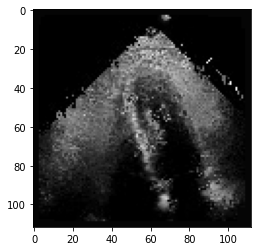

In [43]:
import matplotlib.pyplot as plt
(ef,large_frame, small_frame, large_trace, small_trace),(deformlarge,deformsmall)= next(iter(dataloader))
#y_large = model(deformlarge.float().to(device))['out']   
#y_large = F.normalize(y_large,dim = 1)/2+0.5
img = deformlarge[0].permute((1,2,0)).detach().cpu().numpy()
img[:,:,0]
plt.imshow(img[:,:,0],cmap = 'gray')                                                                             

In [ ]:
large_frame.size(),y_large.size()

In [ ]:
y_large[0][0].size()

In [ ]:
import torch.distributed as dist
import torchvision
import torch
from loss_functions.nt_xent import NTXentLoss
import os
import shutil
import sys
import pickle
from model.conunet import SupConUnet
from model.Resnetunet import ResNetUNet
import tqdm
import os
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config
#from datasets.two_dim.NumpyDataLoader import NumpyDataSet
apex_support = False
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from runepoch import run_epoch
modelseg = torchvision.models.segmentation.deeplabv3_resnet50(aux_loss=False)
modelseg.classifier[-1] = torch.nn.Conv2d(modelseg.classifier[-1].in_channels, 3, kernel_size=modelseg.classifier[-1].kernel_size)  # change number of outputs to 1
# Load best weights
pretrained = True
if pretrained:
    checkpoint = torch.load(os.path.join("pretrained_weights/self", "checkpoint.pt"))
    modelseg.load_state_dict(checkpoint['state_dict'], strict=False)


In [ ]:
from echonet_dataset import Echo
lr=1e-5
weight_decay=1e-5
lr_step_period=None,
optim = torch.optim.SGD(modelseg.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
conf = models_genesis_config()
tasks = ['EF','SmallFrame' , 'LargeFrame', 'SmallTrace' ,'LargeTrace']
kwargs = {"target_type": tasks,
          "mean": 0,
          "std": 1,
          "mode":"self_supervised",
          "conf":conf}
config = get_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
traindataset = Echo(root='/AS_Neda/echonet/', split="train",**kwargs)
# Generating dataloader
dataloader = torch.utils.data.DataLoader(
    traindataset, batch_size=16, num_workers=4, shuffle=True, pin_memory=(device.type == "cuda"), drop_last=True)
modelseg.to(device)
run_epoch(modelseg, dataloader, False, optim, device,config)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

def SupConSegModel(num_classes, in_channels=1, initial_filter_size=64,
                 kernel_size=3, do_instancenorm=True, mode="cls"):

    encoder = torchvision.models.segmentation.deeplabv3_resnet50(aux_loss=False)
    initial_filter_size = encoder.classifier[-1].in_channels
    if mode == 'mlp':
        encoder.classifier[-1] = nn.Sequential(torch.nn.Conv2d(initial_filter_size, 256, kernel_size=1),
                                  torch.nn.Conv2d(256, num_classes, kernel_size=1))
    elif mode == "segmentation":
        encoder.classifier[-1] = torch.nn.Conv2d(encoder.classifier[-1].in_channels, 1, kernel_size=encoder.classifier[-1].kernel_size)  # change number of outputs to 1
    elif mode == "reconstruction":
        encoder.classifier[-1] = torch.nn.Conv2d(encoder.classifier[-1].in_channels, 3, kernel_size=encoder.classifier[-1].kernel_size)  # change number of outputs to 1

    else:
        raise NotImplemented("This mode is not supported yet")

    return encoder

In [2]:
import torch.distributed as dist
import torchvision
import torch
from loss_functions.nt_xent import NTXentLoss
import os
import shutil
import sys
import pickle
from model.conunet import SupConUnet
from model.Resnetunet import ResNetUNet
import tqdm
import os
import echonet_dataloader
from echonet_dataloader import utils
from config import models_genesis_config
from get_config_genesis import get_config
import os
from config import models_genesis_config
#from datasets.two_dim.NumpyDataLoader import NumpyDataSet
apex_support = False
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from runepoch import run_epoch
from echonet_dataset import Echo
conf = models_genesis_config()
tasks = ['EF','SmallFrame' , 'LargeFrame', 'SmallTrace' ,'LargeTrace']
kwargs = {"target_type": tasks,
          "mean": 0,
          "std": 1,
          "mode":"self_supervised",
          "conf":conf}
config = get_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
traindataset = Echo(root='/AS_Neda/echonet/', split="train",**kwargs)
# Generating dataloader
dataloader = torch.utils.data.DataLoader(
    traindataset, batch_size=8, num_workers=4, shuffle=True, pin_memory=(device.type == "cuda"), drop_last=True)


In [3]:
from loss_functions.supcon_loss import SupConSegLoss, LocalConLoss, BlockConLoss
import os
# GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "1,7"

# Set device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get Model
model = SupConSegModel(num_classes=128, mode="mlp")
if device.type == "cuda":
    print("Cuda")
    model = torch.nn.DataParallel(model)
model = model.to(device)

# Loss Function
criterion = LocalConLoss(temperature=0.007, stride=4)

Cuda


In [4]:
(ef,large_frame, small_frame, large_trace, small_trace),_ = next(iter(dataloader))

In [5]:
data1 = small_frame.float()
target1 = small_trace.long()

data2 = large_frame.float()
target2 = large_trace.long()

imgs = torch.cat([data1, data2], dim=0)
labels = torch.cat([target1, target2], dim=0).squeeze(dim=1)  

In [6]:
imgs = imgs.to(device)
labels = labels.to(device)
bsz = labels.shape[0] // 2
img_size = imgs.shape[-1]

In [7]:
features = model(imgs)['out']
features = F.normalize(features, p=2, dim=1)
print(features.size())

torch.Size([16, 128, 112, 112])


In [8]:
f1, f2 = torch.split(features, [bsz, bsz], dim=0)
features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)  # [bsz, n_view, c, img_size, img_size]
l1, l2 = torch.split(labels, [bsz, bsz], dim=0)
labels = torch.cat([l1.unsqueeze(1), l2.unsqueeze(1)], dim=1)
# print(idx, features.device, labels.device)


In [13]:
labels = labels.cpu()
features = features.cpu()
contrast_count = features.shape[1]
contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)  # of size (bsz*v, c, h, w)

kernels = contrast_feature.permute(0, 2, 3, 1)
kernels = kernels.reshape(-1, contrast_feature.shape[1], 1, 1)
# kernels = kernels[non_background_idx]
logits = torch.div(F.conv2d(contrast_feature, kernels), 0.007)  # of size (bsz*v, bsz*v*h*w, h, w)
logits = logits.permute(1, 0, 2, 3)
logits = logits.reshape(logits.shape[0], -1)
logits.size()

torch.Size([200704, 200704])

In [15]:
labels = torch.cat(torch.unbind(labels, dim=1), dim=0)
labels = labels.contiguous().view(-1, 1)
mask = torch.eq(labels, labels.T).float()

bg_bool = torch.eq(labels.squeeze().cpu(), torch.zeros(labels.squeeze().shape))
non_bg_bool = ~ bg_bool
non_bg_bool = non_bg_bool.int()

In [ ]:
device = (torch.device('cuda')
          if features.is_cuda
          else torch.device('cpu'))

if len(features.shape) < 3:
    raise ValueError('`features` needs to be [bsz, n_views, ...],'
                     'at least 3 dimensions are required')

contrast_count = features.shape[1]
contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)  # of size (bsz*v, c, h, w)

kernels = contrast_feature.permute(0, 2, 3, 1)
kernels = kernels.reshape(-1, contrast_feature.shape[1], 1, 1)
# kernels = kernels[non_background_idx]
logits = torch.div(F.conv2d(contrast_feature, kernels), self.temperature)  # of size (bsz*v, bsz*v*h*w, h, w)
logits = logits.permute(1, 0, 2, 3)
logits = logits.reshape(logits.shape[0], -1)

if labels is not None:
    labels = torch.cat(torch.unbind(labels, dim=1), dim=0)
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(device)

    bg_bool = torch.eq(labels.squeeze().cpu(), torch.zeros(labels.squeeze().shape))
    non_bg_bool = ~ bg_bool
    non_bg_bool = non_bg_bool.int().to(device)
else:
    mask = torch.eye(logits.shape[0]//contrast_count).float().to(device)
    mask = mask.repeat(contrast_count, contrast_count)
    # print(mask.shape)

# mask-out self-contrast cases
logits_mask = torch.scatter(
    torch.ones_like(mask),
    1,
    torch.arange(mask.shape[0]).view(-1, 1).to(device),
    0
)
mask = mask * logits_mask

# compute log_prob
exp_logits = torch.exp(logits) * logits_mask
log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

# compute mean of log-likelihood over positive
mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

# loss
loss = - mean_log_prob_pos
# loss = loss.view(anchor_count, batch_size).mean()
if labels is not None:
    # only consider the contrastive loss for non-background pixel
    loss = (loss * non_bg_bool).sum() / (non_bg_bool.sum())
else:
    loss = loss.mean()